## Biodiversity composition changeloss due to land use change
We propose the estimation of biodiversity loss due to land use change which will consist in estimateing the regional species loss,displacement or reduction of species that would otherwise exist in the land if it wouldn't be used for production of a certain commodity as well as the relative abundance within the ecoregion due to land use change.

    Biodiversity loss due to land use change (PDF / year) =  = area with tree cover loss and land use change (hectares) * taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (100000/ 0.0001) (conversion units) *  probability purchase area (Hectare) 

Where:

- Area with tree cover loss and land use change (m2) would e the area of tree cover loss detected for different years using GFW/ sateligence data and where a land use change from either  forest to arable or forest to grassland has taken place. This area will be detected using Hansen data following the approach highlighted here.
- Taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2)
- The multiplication by 10000 gets hectares and the division by 0.0001 converts m2 to hectares
- Probability purchase area is the potential area where a certain commodity has been purchased from. The calculation of this probability purchase area would be done following the workflow highlighted here.

## Land use productivity

In order to track the land use expansion and land productivity, we propose the two formulas below:

    Land use (ha * year) = (Area fraction  * Volume (Tonnes))  / (Total Area fraction * yield (Tonnes / hectare)
    
Where:
- The land use area would be a purchased area for a certain commodity per a certain year. The calculation would be the same as the one described here.
- Area fraction would be the area used for a specific commodity in a h3 grid. This information would be obtained from EarthStat.
- Total Area Fraction would be the sum of all the area fraction from EarthStat in the supply shed. 
- Yield would be the tonnes produced in an hectare obtained from EarthStat.
- Volume would be the Total Volume purchased for a certain commodity by a specific year and location.



    Yield (Tonnes / ha * year) =  Volume (Tonnes) / Land use (ha * year)
    
    Yield (Tonnes / ha * year) = (Total Area fraction * yield (Tonnes / hectare)  /  Area fraction 

Where:

- Volume would be the Total Volume purchased for a certain commodity by a specific year and location.
- The land use area would be a purchased area for a certain commodity per a certain year. The calculation would be the same as the one described here.


### Import libraries

In [7]:
## import libraries
import geopandas as gpd
import pandas as pd

import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt

## Import test user data


In [4]:
test_data = gpd.read_file('../../datasets/raw/india_test_shape.shp')
test_data

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,Total_af,geometry
0,Cotton,None,745,India,None,None,None,Unknown,Low,902.65033,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


## Calculate biodiversity risk map

For cumputing the biodiversity risk maps we willneed the following datasets:

- area with tree cover loss and land use change (hectares) which will be calculated in the deforestation metric
- taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) which will be obtained from https://www.lifecycleinitiative.org/applying-lca/lcia-cf/
-ecoregions data


The biodiversity risk formula is:

Biodiversity loss due to land use change (PDF / year * hectare) =  area with tree cover loss and land use change (hectares) * taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (100000/ 0.0001) (conversion units)



### 1. import taxa aggregated characterisation factors

In [48]:
df = pd.read_excel(r'../../datasets/raw/biodiversity_metric/Ch6 PSLregional v01.xlsx', sheet_name='Transformation_Ecoregion', header=[3])
df.head()

,eco_code,Median,lower 95%,upper 95%,Median.1,lower 95%.1,upper 95%.1,Median.2,lower 95%.2,upper 95%.2,Median.3,lower 95%.3,upper 95%.3,Median.4,lower 95%.4,upper 95%.4,Median.5,lower 95%.5,upper 95%.5
0,World average,2.880992e-12,-4.658128e-13,7.776529e-12,2.312977e-12,-1.304287e-12,8.469779e-12,1.875973e-12,-1.600759e-12,8.391349e-12,4.430366e-12,6.457714e-14,9.039383e-12,6.079169e-13,-9.405671e-13,4.497921e-12,1.478220e-12,-1.604768e-12,7.346928e-12
1,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,3.504606e-11,-1.673912e-11,1.546130e-10,2.438062e-11,-2.792929e-11,1.337088e-10,NaN,NaN,NaN,1.430631e-11,-7.042386e-13,8.071432e-11,3.027136e-11,-1.907786e-11,1.419584e-10
2,AA0102,2.664063e-11,-9.488066e-13,7.426592e-11,2.390119e-11,-3.142746e-12,7.106328e-11,1.220219e-11,-2.413976e-11,6.924044e-11,3.801648e-11,2.257569e-12,8.972848e-11,5.158636e-12,-2.444711e-12,3.797641e-11,1.854157e-11,-8.772367e-12,7.009282e-11
3,AA0103,4.682694e-11,-6.886077e-12,1.544679e-10,3.522323e-11,-1.902498e-11,1.463752e-10,1.899118e-11,-5.536463e-11,1.328678e-10,6.769960e-11,0.000000e+00,1.596704e-10,1.375353e-11,-9.773335e-13,7.622320e-11,2.925349e-11,-1.895998e-11,1.311491e-10
4,AA0104,1.622572e-11,-1.186395e-12,4.908715e-11,1.368277e-11,-4.649506e-12,4.801403e-11,7.269697e-12,-1.919075e-11,4.605131e-11,2.437949e-11,0.000000e+00,5.667906e-11,3.979111e-12,-3.025170e-13,2.479203e-11,1.168076e-11,-5.450018e-12,4.411466e-11


In [49]:
## select for the moment annual crops
pdf_annual_crops =df[['eco_code', 'Median', 'lower 95%', 'upper 95%']]
pdf_annual_crops.head()

,eco_code,Median,lower 95%,upper 95%
0,World average,2.880992e-12,-4.658128e-13,7.776529e-12
1,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10
2,AA0102,2.664063e-11,-9.488066e-13,7.426592e-11
3,AA0103,4.682694e-11,-6.886077e-12,1.544679e-10
4,AA0104,1.622572e-11,-1.186395e-12,4.908715e-11


### 2. Import ecoregions layer

In [40]:
## import the ecoregions data

ecoregions = gpd.read_file('../../datasets/raw/biodiversity_metric/official/wwf_terr_ecos.shp')
ecoregions.head()

,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,...,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,geometry
0,1,29.802942,0.219,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.219475,0.002769,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.26972 29.32648, -112.28809 29.3..."
1,2,11.977824,0.193,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.193289,0.001111,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.19907 29.17528, -112.20740 29.1..."
2,3,77301.372760,111.954,Sinaloan dry forests,NT,2.0,28.0,60228.0,98.0,1.0,...,2.0,1.0,111.951414,6.879188,77362,NT0228,0.0,0.0,0.0,"POLYGON ((-109.11700 27.74142, -109.11228 27.7..."
3,4,215.489182,1.274,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,1.273654,0.019701,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.54179 27.38383, -110.54462 27.3..."
4,5,19.639089,0.363,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.363068,0.001791,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.52850 27.28641, -110.53336 27.2..."


### 3. Join ecoregions layer with the taxa caracterization factors by ecoregion

In [53]:

ecoregions_PDF = pd.merge(
    pdf_annual_crops,
    ecoregions,
    how= 'inner',
    on='eco_code')
ecoregions_PDF.head()

,eco_code,Median,lower 95%,upper 95%,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,...,G200_NUM,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,PER_area,PER_area_1,PER_area_2,geometry
0,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,10900,16.678311,0.198,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.198109,0.001356,2099,0.0,0.0,0.0,"POLYGON ((147.59106 -2.09207, 147.57886 -2.090..."
1,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11856,1874.284908,2.880,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,2.879881,0.152367,2099,0.0,0.0,0.0,"POLYGON ((146.81030 -1.96906, 146.81750 -1.964..."
2,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11865,12.722658,0.155,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.155184,0.001034,2099,0.0,0.0,0.0,"POLYGON ((147.39548 -1.99151, 147.41811 -2.001..."
3,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11932,12.841929,0.120,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.120138,0.001044,2099,0.0,0.0,0.0,"POLYGON ((147.27190 -2.54659, 147.28200 -2.541..."
4,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11678,8.700576,0.134,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.134267,0.000707,2099,0.0,0.0,0.0,"POLYGON ((144.20190 -1.40101, 144.19025 -1.399..."


In [54]:
ecoregions_PDF = ecoregions_PDF.set_geometry('geometry')

In [57]:
# export
ecoregions_PDF.to_file(
    '../../datasets/processed/taxa_aggregated_characterization_factors.shp',
    driver='ESRI Shapefile'
)

### Generate raster for the taxa aggregated characterization factors by ecoregion.

In [58]:
!gdal_rasterize -l taxa_aggregated_characterization_factors -a Median -tr 0.0833333333333286 0.0833333333333286 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff '../../datasets/processed/taxa_aggregated_characterization_factors.shp' '../../datasets/processed/taxa_aggregated_characterization_factors_4326.tif'




0...10...20...30...40...50...60...70...80...90...100 - done.


In [1]:
!gdalinfo -stats -hist '../../datasets/processed/taxa_aggregated_characterization_factors_4326.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/taxa_aggregated_characterization_factors_4326.tif
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,90.000000000000000)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-180.0000000,  90.0000000) (180d 0' 0.00"W, 90d 0' 0.00"N)
Lower Left  (-180.0000000, -90.0000000) (180

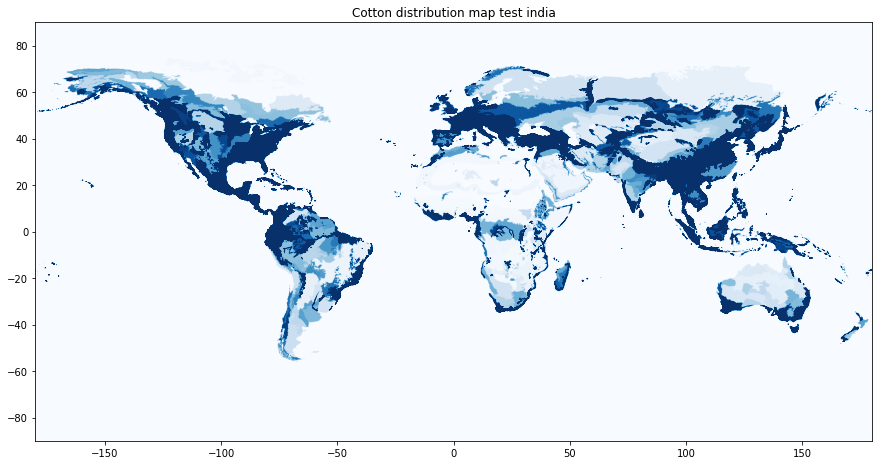

In [15]:
#check calculated risk map
with rio.open('../../datasets/processed/taxa_aggregated_characterization_factors_4326.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    #ax.set_ylim((-5,40))
    #ax.set_xlim((60,100))
    rio.plot.show(dat, vmin=2.8999999152285e-14, vmax=2.9376220100729e-12, cmap='Blues', ax=ax, transform=src.transform)
    #test_gdf.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title('Cotton distribution map test india')

### 4. Intersect the TACF with the deforestation by commodity

In [ ]:
## intersect two rasters once deforestation is done

## Calculate biodiversity impact metric